In [1]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

In [2]:
from branchynet.net import BranchyNet
from branchynet.links import *
import chainer.functions as F
import chainer.links as L
from branchynet import utils, visualize
from chainer import cuda

Define Network

In [3]:
from networks import lenet_mnist

branchyNet = lenet_mnist.get_network()
if cuda.available:
    branchyNet.to_gpu()
branchyNet.training()

Import Data

In [4]:
from datasets import mnist
x_train, y_train, x_test, y_test = mnist.get_data()

Settings

In [5]:
TRAIN_BATCHSIZE = 512
TEST_BATCHSIZE = 1
TRAIN_NUM_EPOCHS = 100

Train Main Network

In [6]:
main_loss, main_acc, main_time = utils.train(branchyNet, x_train, y_train, main=True, batchsize=TRAIN_BATCHSIZE,
                                             num_epoch=TRAIN_NUM_EPOCHS)

Train BranchyNet

In [7]:
TRAIN_NUM_EPOCHS = 100
branch_loss, branch_acc, branch_time = utils.train(branchyNet, x_train, y_train, batchsize=TRAIN_BATCHSIZE,
                                                   num_epoch=TRAIN_NUM_EPOCHS)

#set network to inference mode
branchyNet.testing()

Visualizing Network Training

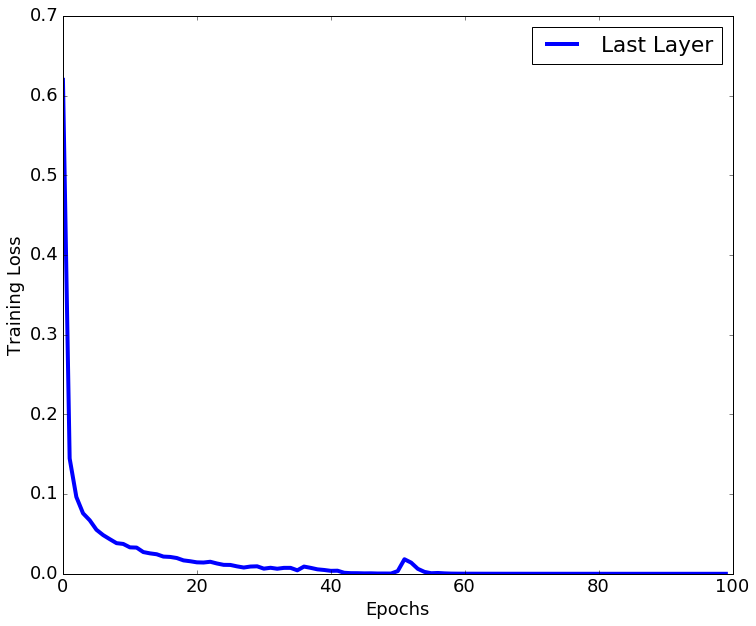

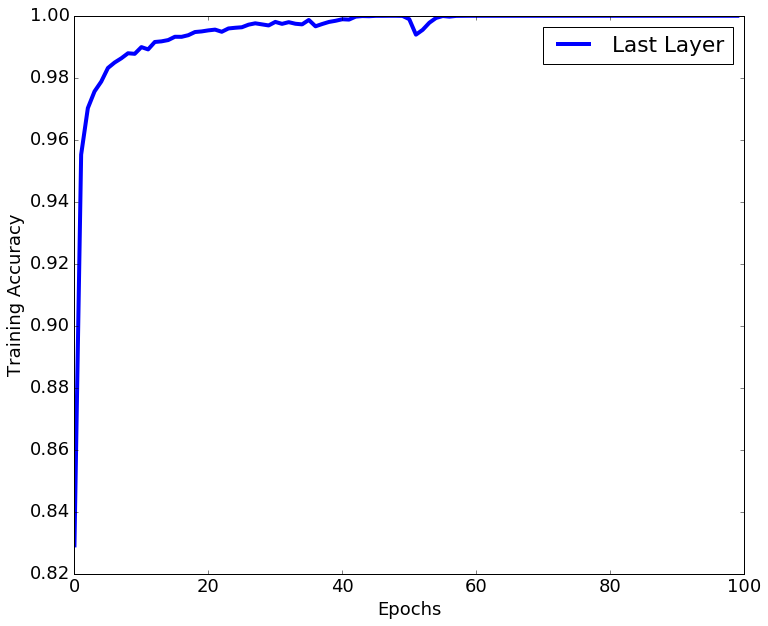

In [8]:
visualize.plot_layers(main_loss, xlabel='Epochs', ylabel='Training Loss')
visualize.plot_layers(main_acc, xlabel='Epochs', ylabel='Training Accuracy')

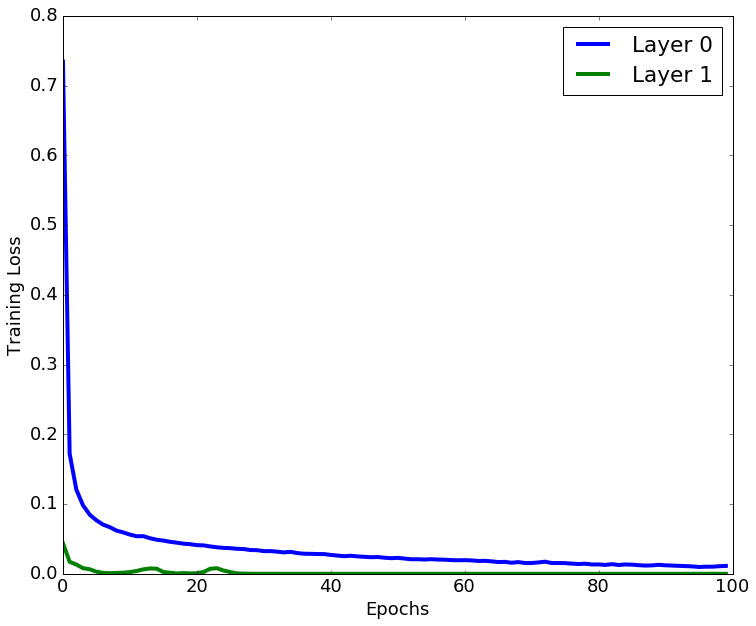

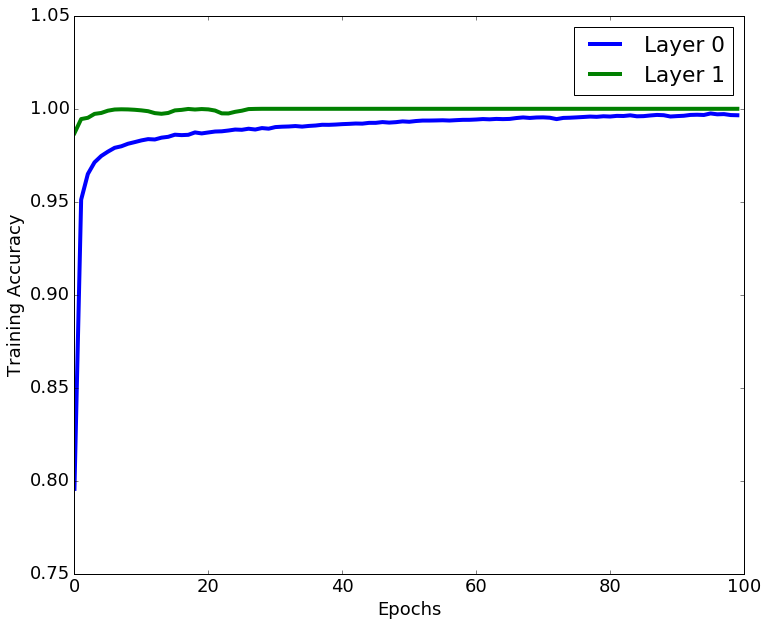

In [9]:
visualize.plot_layers(zip(*branch_loss), xlabel='Epochs', ylabel='Training Loss')
visualize.plot_layers(zip(*branch_acc), xlabel='Epochs', ylabel='Training Accuracy')

Run test suite and visualize

In [10]:
#set network to inference mode
branchyNet.testing()
branchyNet.verbose = False
if cuda.available:
    branchyNet.to_gpu()
g_baseacc, g_basediff, _, _ = utils.test(branchyNet, x_test, y_test, main=True, batchsize=TEST_BATCHSIZE)
g_basediff = (g_basediff / float(len(y_test))) * 1000.

#branchyNet.to_cpu()
c_baseacc, c_basediff, _, _ = utils.test(branchyNet, x_test, y_test, main=True, batchsize=TEST_BATCHSIZE)
c_basediff = (c_basediff / float(len(y_test))) * 1000.

In [11]:
# Specify thresholds
thresholds = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1., 2., 3., 5., 10.]

In [12]:
#GPU
if cuda.available:
    branchyNet.to_gpu()
g_ts, g_accs, g_diffs, g_exits = utils.screen_branchy(branchyNet, x_test, y_test, thresholds,
                                                    batchsize=TEST_BATCHSIZE, verbose=True)

#convert to ms
g_diffs *= 1000.

C:\Users\Kung Lab\Miniconda2\lib\site-packages\matplotlib\__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


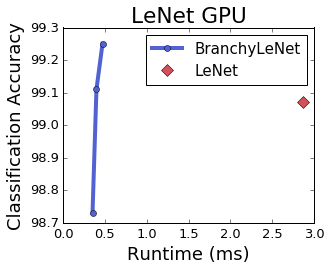

In [13]:
visualize.plot_line_tradeoff(g_accs, g_diffs, g_ts, g_exits, g_baseacc, g_basediff, all_samples=False, inc_amt=-0.0001,
                             our_label='BranchyLeNet', orig_label='LeNet', xlabel='Runtime (ms)', 
                             title='LeNet GPU', output_path='_figs/lenet_gpu.pdf')

In [14]:
#CPU
branchyNet.to_cpu()
c_ts, c_accs, c_diffs, c_exits  = utils.screen_branchy(branchyNet, x_test, y_test, thresholds,
                                                       batchsize=TEST_BATCHSIZE, verbose=True)

#convert to ms
c_diffs *= 1000.

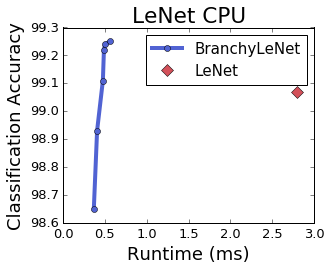

In [15]:
visualize.plot_line_tradeoff(c_accs, c_diffs, c_ts, c_exits, c_baseacc, c_basediff, all_samples=False, inc_amt=-0.0001,
                             our_label='BranchyLeNet', orig_label='LeNet', xlabel='Runtime (ms)',
                             title='LeNet CPU', output_path='_figs/lenet_cpu.pdf')

In [61]:
print('CPU Results:')
utils.branchy_table_results('LeNet', c_baseacc, c_basediff, c_accs, c_diffs, c_exits, c_ts)

print('\n\n')

print('GPU Results:')
utils.branchy_table_results('LeNet-MNIST', g_baseacc, g_basediff, g_accs, c_diffs, g_exits, g_ts)

CPU Results:
        Network        Acc.(%)       Time(ms)           Gain      Thrshld.T        Exit(%)
          LeNet          99.07           2.79              -              -              -
        B-LeNet          99.20           1.01           2.77       {0.0001} {71.57, 28.43}
        B-LeNet          99.21           0.75           3.70       {0.0005} {81.05, 18.95}
        B-LeNet          99.21           0.77           3.64        {0.001} {84.24, 15.76}
        B-LeNet          99.23           0.62           4.52        {0.005}  {90.19, 9.81}
        B-LeNet          99.23           0.59           4.77         {0.01}    {92.1, 7.9}
        B-LeNet          99.25           0.56           4.96        {0.025}  {93.95, 6.05}
        B-LeNet          99.23           0.51           5.49         {0.05}  {95.11, 4.89}
        B-LeNet          99.24           0.50           5.58        {0.075}  {95.71, 4.29}
        B-LeNet          99.22           0.49           5.72          {0.1}  

Save model/data

In [18]:
import dill
branchyNet.to_cpu()
with open("_models/lenet_mnist.bn", "wb") as f:
    dill.dump(branchyNet, f)
with open("_models/lenet_mnist_gpu_results.pkl", "wb") as f:
    dill.dump({'accs': g_accs, 'rt': g_diffs, 'exits': g_exits, 'ts': g_ts, 'baseacc': g_baseacc, 'basediff': g_basediff}, f)
with open("_models/lenet_mnist_cpu_results.pkl", "wb") as f:
    dill.dump({'accs': c_accs, 'rt': c_diffs, 'exits': c_exits, 'ts': c_ts, 'baseacc': c_baseacc, 'basediff': c_basediff}, f)

In [54]:
import dill
with open("_models/lenet_mnist_gpu_results.pkl", "rb") as f:
    gpu_res = dill.load(f)
with open("_models/lenet_mnist_cpu_results.pkl", "rb") as f:
    cpu_res = dill.load(f)